In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import re

In [2]:
train_data = pd.read_csv("train_data.csv",names=["sentiments", "reviews"])

FileNotFoundError: [Errno 2] No such file or directory: 'train_data.csv'

In [ ]:
def basic_cleaning(data_frame):
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.lower())
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.translate(str.maketrans('', '', string.punctuation)))
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: review.translate(str.maketrans('', '', string.digits)))
    data_frame['reviews'] = data_frame.reviews.apply(lambda review: re.sub("r[^a-z]",'',review))

    
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_data(data_frame):
    data_frame['words'] = data_frame.reviews.apply(lambda review: nltk.word_tokenize(review))

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(list):
    stop_words_removed = []
    for i in list:
        if i not in stopwords:
            stop_words_removed.append(i)
    return stop_words_removed

In [ ]:
# nltk.download('all')
#tag part of speech to get more accurate word during lemmatizaton
def tag_pos(list_of_words):
    return nltk.pos_tag(list_of_words)

#extraction of lemma words after pos taggin 
from nltk.stem import WordNetLemmatizer
lemmatizer= WordNetLemmatizer()

def find_lemma_word(word):
    lemma_words=[]
    words_with_pos = tag_pos(word)
    for word in words_with_pos:
        if word[1].startswith('NN'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='n'))
        elif word[1].startswith('VB'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='v'))
        elif word[1].startswith('JJ'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='a'))
        elif word[1].startswith('RB'):
            lemma_words.append(lemmatizer.lemmatize(word[0],pos='r'))
        else:
            lemma_words.append(word[0])
            
    return lemma_words

In [3]:
basic_cleaning(train_data)
tokenize_data(train_data)
train_data['stop_words_cleaned'] = train_data.words.apply(lambda word_list: remove_stopwords(word_list))
train_data['lemma_word'] = train_data.stop_words_cleaned.apply(lambda word_list: find_lemma_word(word_list))
train_data['cleaned_review'] = train_data.lemma_word.apply(lambda review_list: " ".join(review_list))

NameError: name 'basic_cleaning' is not defined

In [4]:
train_data

NameError: name 'train_data' is not defined

In [5]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_sentiment, test_sentiment =train_test_split(train_data.cleaned_review,train_data.sentiments,shuffle=True,random_state=0,stratify=train_data.sentiments,train_size=.85)

NameError: name 'train_data' is not defined

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(min_df=.01,use_idf=False,ngram_range=(1,2))
feature_matrix = tf_vectorizer.fit_transform(train_review)
feature_array = feature_matrix.toarray()

NameError: name 'train_review' is not defined

In [7]:
vocab_list = tf_vectorizer.get_feature_names_out()
vocab_list

NotFittedError: Vocabulary not fitted or provided

### Select K-best features

In [8]:
from sklearn.feature_selection import SelectKBest, chi2

vocab_list = tf_vectorizer.get_feature_names_out()

select_k_best = SelectKBest(score_func=chi2, k= int(len(vocab_list)*.10))
train_sentiment_np_array = np.array(train_sentiment)
select_k_best.fit(feature_array, train_sentiment_np_array)
mask = select_k_best.get_support()
k_best_feature = vocab_list[mask]
k_best_feature

NotFittedError: Vocabulary not fitted or provided

In [9]:
k_best_feature.shape

NameError: name 'k_best_feature' is not defined

### Supervised Chi-Square weight for k-best term by utilising target value

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
selected_tf_vectorizer = TfidfVectorizer(use_idf=True, vocabulary=k_best_feature, sublinear_tf=True, ngram_range=(1,2))
selected_feat_array = selected_tf_vectorizer.fit_transform(train_review).toarray()
selected_test_array = selected_tf_vectorizer.transform(test_review).toarray()
observed_value_table = pd.DataFrame(selected_tf_vectorizer.get_feature_names_out(), columns=['features'])

NameError: name 'k_best_feature' is not defined

In [11]:
selected_tf_vectorizer.get_feature_names_out()

NameError: name 'selected_tf_vectorizer' is not defined

In [12]:
tf_data_frame = pd.DataFrame(selected_feat_array,columns = selected_tf_vectorizer.get_feature_names_out())
tf_data_frame['sentiments'] = np.array(train_sentiment)

NameError: name 'selected_feat_array' is not defined

In [13]:
observed_value_table['positive_sentiment'] = observed_value_table.features.apply(lambda feature: tf_data_frame.loc[tf_data_frame['sentiments']==1,feature].sum())

NameError: name 'observed_value_table' is not defined

In [14]:
observed_value_table['negative_sentiment'] = observed_value_table.features.apply(lambda feature: tf_data_frame.loc[tf_data_frame['sentiments']==-1,feature].sum())

NameError: name 'observed_value_table' is not defined

In [15]:
observed_value_table['total_row_count'] = observed_value_table['positive_sentiment'] + observed_value_table['negative_sentiment']

NameError: name 'observed_value_table' is not defined

In [16]:
tf_data_frame['really good'].sum()

NameError: name 'tf_data_frame' is not defined

In [17]:
observed_value_table

NameError: name 'observed_value_table' is not defined

In [18]:
chi_sqare_expected = pd.DataFrame()

#### Calculating expected value table for chi-sqare function

In [19]:
def chi_sqare_value(row_totals, positive_column_total, negative_column_total, total_sum):
    positive_chi_value = []
    negative_chi_value = []
    for i in range(0, len(row_totals)):
        positive_chi_value.append((row_totals[i]*positive_column_total)/total_sum)
        negative_chi_value.append((row_totals[i]*negative_column_total)/total_sum)
    return positive_chi_value, negative_chi_value

In [20]:
row_totals = np.array(observed_value_table['total_row_count'])
positive_column_total = observed_value_table['positive_sentiment'].sum()
negative_column_total = observed_value_table['negative_sentiment'].sum()
total_sum = observed_value_table['total_row_count'].sum()
expected_positive, expected_negative = chi_sqare_value(row_totals, positive_column_total, negative_column_total, total_sum)

NameError: name 'observed_value_table' is not defined

In [21]:
chi_sqare_expected['+1'] = np.array(expected_positive)
chi_sqare_expected['-1'] = np.array(expected_negative)

NameError: name 'expected_positive' is not defined

In [22]:
chi_sqare_expected

""


In [23]:
chi_sqare_table = pd.DataFrame()

In [24]:
chi_sqare_table['positiev_sentiments'] = ((observed_value_table['positive_sentiment'] - chi_sqare_expected['+1'])**2)/chi_sqare_expected['+1']
chi_sqare_table['negatiev_sentiments'] = ((observed_value_table['negative_sentiment'] - chi_sqare_expected['-1'])**2)/chi_sqare_expected['-1']
chi_sqare_table['sum'] = chi_sqare_table['positiev_sentiments'] + chi_sqare_table['negatiev_sentiments']

NameError: name 'observed_value_table' is not defined

In [25]:
chi_sqare_table

""


### Create weighted features

In [26]:
def generate_chi_sqare_weighted_features(train_feat_array, chi_weight):
    new_weighted_feature= []
    sentiments = np.array(train_feat_array)
    for i in range(0,len(sentiments)):
            new_weighted_feature.append(np.multiply(train_feat_array[i], chi_weight))
    return new_weighted_feature        

In [27]:
def weight_unlabled_data(features, max_chi_val):
    weighted_data = []
    for i in range(0,len(features)):
        weighted_data.append(np.multiply(features[i], max_chi_val))
    return np.array(weighted_data)

In [28]:
chi_weight = np.array (chi_sqare_table['sum'])
weighted_selected_feat = np.array(
    generate_chi_sqare_weighted_features(selected_feat_array, chi_weight))

KeyError: 'sum'

In [29]:
chi_sqare_table

""


In [30]:
test_sentiments_array = np.array(test_sentiment)
train_sentiments_array = np.array(train_sentiment)
# chi_sqare_table['max_chi_value'] = find_max_chi_val(chi_sqare_table['positiev_sentiments'], chi_sqare_table['negatiev_sentiments'])
weighted_test_feat = weight_unlabled_data( selected_test_array, chi_weight)
max_neighbour =np.sqrt(int(len(weighted_selected_feat)))
max_neighbour = np.ceil(max_neighbour)

NameError: name 'test_sentiment' is not defined

In [31]:
from sklearn.decomposition import TruncatedSVD
truncated_svd = TruncatedSVD(n_components=2)
new_feat_train = truncated_svd.fit_transform(weighted_test_feat, train_sentiments_array)
feat_test = truncated_svd.transform(weighted_test_feat)

In [613]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
track_precision=[]
error = []
maxi_k = -1
curr_socre=0
classifer_saved = KNeighborsClassifier()
for i in range(3,60):
    print(i)
    classifer = KNeighborsClassifier(n_neighbors=i,n_jobs=3,weights='distance')
    classifer.fit(weighted_selected_feat, train_sentiments_array)
    sentiments_predict = classifer.predict(weighted_test_feat)
    score = metrics.accuracy_score(test_sentiments_array,sentiments_predict)
    print(score)
    track_precision.append(score)
    error.append(1-score)
    if score>curr_socre:
        curr_socre = score
        maxi_k = i
        classifer_saved = classifer

3
0.794074074074074
4
0.8051851851851852
5
0.807037037037037
6
0.8085185185185185
7
0.8107407407407408
8
0.81
9
0.8122222222222222
10
0.8144444444444444
11
0.8196296296296296
12
0.8203703703703704
13
0.8222222222222222
14
0.8214814814814815
15
0.8225925925925925
16
0.8218518518518518
17
0.8211111111111111
18
0.8218518518518518
19
0.8192592592592592
20
0.8225925925925925
21
0.8177777777777778
22
0.8188888888888889
23
0.817037037037037
24
0.8185185185185185
25
0.8185185185185185
26
0.817037037037037
27
0.8166666666666667
28
0.8192592592592592
29
0.8162962962962963
30
0.8181481481481482
31
0.817037037037037
32
0.8181481481481482
33
0.8159259259259259
34
0.8166666666666667
35
0.8177777777777778
36
0.8188888888888889
37
0.8203703703703704
38
0.8174074074074074
39
0.82
40
0.8174074074074074
41
0.8166666666666667
42
0.8162962962962963
43
0.8155555555555556
44
0.8155555555555556
45
0.8155555555555556
46
0.8144444444444444
47
0.8155555555555556
48
0.8148148148148148
49
0.8140740740740741
50
0.8

In [614]:
curr_socre, maxi_k

(0.8225925925925925, 15)

In [615]:
# from sklearn.metrics.pairwise import euclidean_distances
# def calculate_uclidien_distance(train_data, test_data):
#     print("calculate_uclidien_distance in")
#     uc_distance = euclidean_distances([train_data],[test_data])
#     print("calculate_uclidien_distance out")
#     return 1/((np.sqrt(uc_distance))**2)        

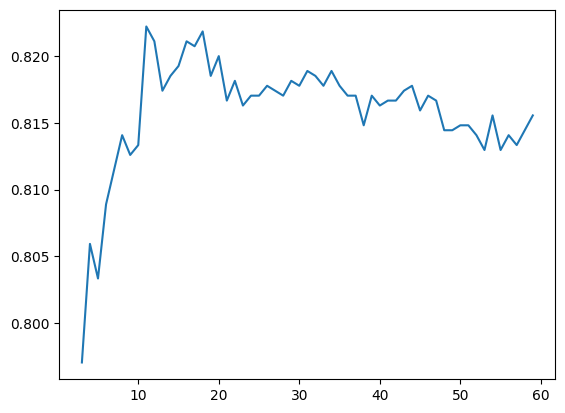

In [498]:
plt.plot(range(3,60),track_precision)

In [ ]:
# df = pd.DataFrame(weighted_selected_feat)

In [ ]:
def calculate_neighbour(train_data, test_data, K):
    
    numpy_distances = np.array(euclidean_distances(train_data,[test_data]).flatten())
    inv_distance = []
        
    indexes_by_shortest_dist = numpy_distances.argsort()   
    
    return indexes_by_shortest_dist

In [ ]:
def find_majority_and_predict(train_data, test_data, train_sentiments, K):
    
    nearest_neighbors_indexes = calculate_neighbour(train_data, test_data, K)
    sentiment_classes = []
    
    for i in nearest_neighbors_indexes:
        sentiment_classes.append(train_sentiments[i])
        
    return max(sentiment_classes, key=sentiment_classes.count)

In [ ]:
predicted_sentiments = []
print(len(weighted_test_feat))
for i in range(0,len(weighted_test_feat)):
    print(i)
    predicted_sentiments.append(find_majority_and_predict(weighted_selected_feat,weighted_test_feat[i], train_sentiments_array, 24))
    

In [ ]:
def find_accuracy(predicted_sentiment, real_sentiment):
    correct_prediction = 0
    for i in range(0,len(predicted_sentiments)):
        if predicted_sentiment[i] == real_sentiment[i]:
            correct_prediction += 1
    return np.divide(correct_prediction, len(predicted_sentiment))

In [ ]:
find_accuracy(predicted_sentiments,test_sentiments_array)

In [290]:
result_test_df = pd.read_csv('1661892619_9579706_test_file.csv', names=['reviews'])
basic_cleaning(result_test_df)
tokenize_data(result_test_df)
result_test_df['stop_words_cleaned'] = result_test_df.words.apply(lambda word_list: remove_stopwords(word_list))
result_test_df['lemma_word'] = result_test_df.stop_words_cleaned.apply(lambda word_list: find_lemma_word(word_list))
result_test_df['cleaned_review'] = result_test_df.lemma_word.apply(lambda review_list: " ".join(review_list))
unlabeled_test_feat_matrix = selected_tf_vectorizer.transform(result_test_df['cleaned_review']).toarray()

In [ ]:
unlabeled_test_feat_matrix.shape

In [ ]:
# def find_max_chi_val(a,b):
#     max_chi = []
#     x = np.array(a)
#     y = np.array(b)
#     for i in range(0, len(x)):
#         max_chi.append(max(x[i],y[i]))
#     return np.array(max_chi)

In [291]:
# chi_sqare_table['max_chi_value'] = find_max_chi_val(chi_sqare_table['positiev_sentiments'], chi_sqare_table['negatiev_sentiments'])
chi_sqare_table

,positiev_sentiments,negatiev_sentiments,sum
0,100.987511,93.001330,193.988842
1,94.951223,87.442397,182.393620
2,42.049707,38.724379,80.774086
3,40.112482,36.940352,77.052834
4,15.777274,14.529594,30.306868
...,...,...,...
105,52.167794,48.042319,100.210113
106,20.704853,19.067495,39.772348
107,23.487752,21.630320,45.118072
108,20.752573,19.111442,39.864015


In [292]:
def weight_unlabled_data(features, max_chi_val):
    weighted_data = []
    for i in range(0,len(features)):
        weighted_data.append(np.multiply(features[i], max_chi_val))
    return np.array(weighted_data)

In [293]:
unlabled_weighted_data = weight_unlabled_data(unlabeled_test_feat_matrix, chi_sqare_table['sum'])

In [294]:
unlabled_weighted_data.shape

(18000, 110)

In [295]:
predicted_sentiments = []
print(len(unlabled_weighted_data))
for i in range(0,len(unlabled_weighted_data)):
    print(i)
    predicted_sentiments.append(find_majority_and_predict(weighted_selected_feat,unlabled_weighted_data[i], train_sentiments_array, 24))
    

18000
0


NameError: name 'find_majority_and_predict' is not defined

In [296]:
predicted_values = classifer_saved.predict(unlabled_weighted_data)

In [297]:
predicted_values.shape

(18000,)

In [298]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_values))
outfile.close()

In [299]:
1/(10**2)

0.01